In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

# Perlin Noise
The article was developed by **Daniel Yordanov** <br>
Softuni Username: **dakataebg**

### Contents:

1. [What is Noise?](#what_is_noise)
2. [What is Perlin Noise?](#what_is_perlin_noise)
3. [How does it work?](#how_does_it_work)
    1. [Grids](#grids)
    2. [Gradient vectors](#gradient_vectors)
    3. [Distance vectors](#distance_vectors)
    4. [Dot product](#dot_product)
    5. [Interpolation](#interpolation)
    6. [Fade](#fade)
    7. [Wrap up](#wrap_up)

## What is Noise? <a id="what_is_noise" />
Noise is random values wich have no relationship between each other. We can generate random noise by calling a *pseudorandom generator* in however many dimensions we want.

We can have "uniform noise" - each point in our noise space will have an equal chance (probability) of being selected.

**Example:**

In [3]:
def show_1D_uniform_noise(size, title):
    x = list(range(size))
    y = np.random.random(size) 
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('random value')
    plt.plot(x, y,label="random value")
    plt.legend()
    plt.show()

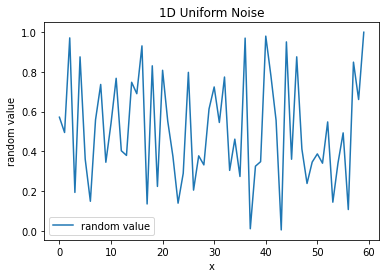

In [4]:
show_1D_uniform_noise(size=60, title="1D Uniform Noise")

In [5]:
def show_image(img_matrix, title, cmap="viridis"):
    plt.imshow(img_matrix, cmap=cmap)
        
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    
def show_2D_uniform_noise(size, title):
    img_matrix = np.random.rand(size, size)
    show_image(img_matrix, title)

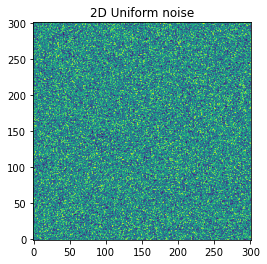

In [6]:
show_2D_uniform_noise(size=301, title="2D Uniform noise")

In the image above, everybody can tell that the pixels have no connection with each other.

## What is Perlin Noise? <a id="what_is_perlin_noise" />

Perlin Noise is an algorithm often used in procedural content generation. It generates pseudo-random noise with a more organic look. 

Ken Perlin developed Perlin noise in 1983 as a result of his frustration with the "machine-like" look of computer-generated imagery (CGI) at the time. It is especially useful for games and other visual media such as movies. In game development, Perlin Noise can be used for any sort of wave-like, undulating material or texture. These effects mostly represent Perlin noise in the 2nd and 3rd dimensions, but it can be extended into the 4th dimension rather trivially. Additionally Perlin Noise can be used in only 1 dimension for purposes such as side-scrolling terrain (such as in Terraria or Starbound) or to create the illusion of handwritten lines.

If you extend Perlin Noise into an additional dimension and consider the extra dimension as time, you can animate it. For example, 2D Perlin Noise can be interpreted as Terrain, but 3D noise can similarly be interpreted as undulating waves in an ocean scene.

**Example:**

<img src="perlin_noise_img_example.png" width="270px">

You can see how fluently pixels colour merge.

## How does it work? <a id="how_does_it_work" />

I will explain how it works by showing how to colour an image with Perlin Noise. All images are 2D matrices, so we will look at how 2D Perlin Noise works. To lower the complexity level, we will have images with equal width and height.

A scalar value for any point in 2D: $ \text{perlin_noise}(x, y) = N, N \in [0.0, 1.0] $

In [7]:
def draw_image_pixels(size):
    """
    Plots a matrix of points.
    """
    side = list(range(1, size + 1))
    x = side * size
    y = np.repeat(side, size)
    plt.plot(x, y, "o", c="dodgerblue")
    return

def draw_image_matrix(size):
    """
    Plots image matrix borders.
    """
    start = 0.5
    end = size + 0.5
    plt.plot([start, end, end, start, start], [start, start, end, end, start], color="black")
    draw_image_pixels(size)
    return
   
def show(title):
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    return

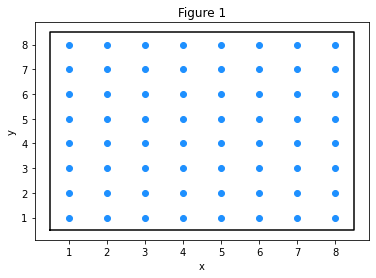

In [8]:
draw_image_matrix(size=8)
show("Figure 1")

#### 1) Grids <a id="grids" />
In figure 1, we can see the empty image matrix where each blue point represents a pixel. <br>
By grouping the pixels into square grids, we can regulate the granularity of the final output by changing their size. <br>
Example: [Image Source](https://www.youtube.com/watch?v=MJ3bvCkHJtE)

<img src="./granularity_img.png" width="600px">

In [9]:
def get_grids_points(matrix_size, grid_ratio):
    """
    Matrix size: The image matrix size.
    Grid ratio: What the grid size would be out of the whole matrix. 
    """

    # If matrix size is not divisible by grid ratio, we decrease the size until it becomes divisible
    while matrix_size % grid_ratio != 0:
        grid_ratio -= 1
        
    grid_size = int(matrix_size / grid_ratio)
    
    # We add 2 to matrix size in order matrix_size to be inside the side array 
    side = np.arange(1, matrix_size + 2, grid_size)
    
    side_length = len(side)
    # We reduce them with 0.5 to make them more visible
    x_axis = np.tile(side, side_length) - 0.5
    y_axis = np.repeat(side, side_length) - 0.5

    return [x_axis, y_axis, grid_size, side_length]

def plot_grids_points(x, y):
    plt.plot(x, y, "o", c="red")

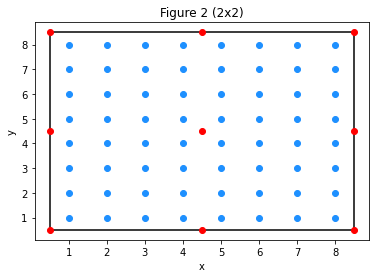

In [10]:
matrix_size = 8
grid_ratio = 2
x, y, _, _ = get_grids_points(matrix_size, grid_ratio)

draw_image_matrix(matrix_size)
plot_grids_points(x, y)
show("Figure 2 (2x2)")

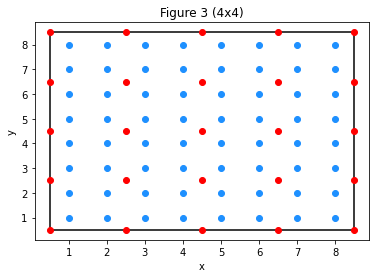

In [11]:
matrix_size = 8
grid_ratio = 4
x, y, _, _ = get_grids_points(matrix_size, grid_ratio)

draw_image_matrix(matrix_size)
plot_grids_points(x, y)
show("Figure 3 (4x4)")

#### 2) Gradient vectors <a id="gradient_vectors" />
In figures 3 and 4, we can see many red points that form square grids - they are groups of image pixels. For each forming a grid point we need to generate random vectors called gradient vectors. These must be uniformly distributed in all directions. Because of that, we will calculate them with $ \sin $ and $ \cos $. In 2D we can use an array of 4 or 8 vectors.
<img src="./gradient_vectors_2d.png" width="600px">
[Image Source](https://www.youtube.com/watch?v=MJ3bvCkHJtE)
<img src="./gradient_vectors_3d.png" width="600px">
[Image Source](https://www.youtube.com/watch?v=MJ3bvCkHJtE)

We are going to use 8 vectors.

In [12]:
def get_gradient_vectors(grid_points_count, vectors_count = 8):
    """
    Generates a list with two elements: Destination points x and y.
    We generate unique vectors with sin and cos. 
    To choose grid_points_count of them we use random choise.
    """
    v = np.linspace(0, 2 * np.pi, vectors_count + 1)
    vx = np.cos(v)
    vy = np.sin(v)
    
    vector_indexes = list(range(vectors_count))
    random_indexes = np.random.choice(vector_indexes, size=grid_points_count)
    u = [vx[idx] for idx in random_indexes]
    v = [vy[idx] for idx in random_indexes]
    
    return list(zip(u, v))

def plot_gradient_vectors(x, y, u, v):
    plt.quiver(x, y, u, v, scale=6, color="orangered")

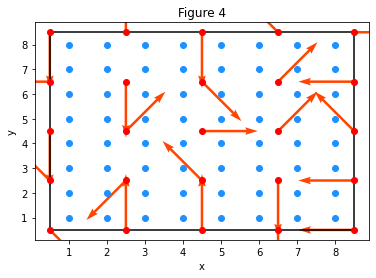

In [13]:
matrix_size = 8
grid_ratio = 4
x, y, _, _ = get_grids_points(matrix_size, grid_ratio)
gradient_vectors = get_gradient_vectors(len(x))
u = [g[0] for g in gradient_vectors]
v = [g[1] for g in gradient_vectors]

draw_image_matrix(matrix_size)
plot_grids_points(x, y)
plot_gradient_vectors(x, y, u, v)
show("Figure 4")

#### 3) Distance vectors <a id="distance_vectors" />
Distance vectors are the vectors from each image pixel to each grid point. 
In the picture bellow the distance vectors are in green. [Image Source](https://www.youtube.com/watch?v=MJ3bvCkHJtE)

<img src="./distance_vector_img.png" width="600px">

We will create a array with the relative distance of each pixel to the gradient vectors that surround it. We generate the array only once as it is applicable for all pixels.

```python
distances = np.linspace(0, 1, grid_size)
```

From it we can retrieve the distances from the point to the grids:

In [14]:
def get_distance_vectors(x, y, grid_size, distances):
    # Compute x and y locations in the grid
    gr_x = x % grid_size
    gr_y = y % grid_size
    
    # Distance vectos (bottom left, bottom right, top left, top right)
    dbl = [distances[gr_x], distances[gr_y]]
    dbr = [distances[gr_x] - 1, distances[gr_y]]
    dtl = [distances[gr_x], distances[gr_y] - 1]
    dtr = [distances[gr_x] - 1, distances[gr_y] - 1]
    
    return [dbl, dbr, dtl, dtr]

#### 4) Dot product <a id="dot_product" />
Next, we take the dot product of the the gradient vectors and the distance vectors. The dot product returns a number. This gives us the influence values.
* If vectors are pointing in the same direction, the Dot Product would reach maximum positive value.
* If vectors are pointing in the opposite directions, the Dot Product would reach maximum negative value.
* If vectors are perpendicular to each other, the Dot Product value is 0.

$$ \vec{gradient} \cdot \vec{distance} = \text{gradient}_x \text{distance}_x + \text{gradient}_y \text{distance}_y = \text{influence} $$

We must have 4 dot products for 2D Noise and 8 for 3D. <br>

In [15]:
def get_dot_product(gradientV, distanceV):
    return gradientV[0] * distanceV[0] + gradientV[1] * distanceV[1]

#### 5) Interpolation <a id="interpolation" />
After this we have to compute the bilinear interpolation of the influence values with the grid point in order to combine the dot product values. <br>
Bilinear interpolation is performed using linear interpolation. We are will need to linearly interpolate three times to find the approximate value.
$$ lerp(a, b, w) = (b - a) \times w + a $$
We calculate the interpolation between $a$ and $b$. <br>
The value $w$ is a weight and is between 0 and 1. Higher values of $w$ bias the interpolation towards $a$, whereas lower values of $w$ bias the intrpolation towards $b$.

In [16]:
def get_bilinear_interpolation(a, b, w):
    """
    Use this cubic interpolation instead, for a smooth appearance:
    return (b - a) * (3.0 - w * 2.0) * (w ** 2) + a
    
    Use this one for an even smoother result with a second derivative equal to zero on boundaries:
    return (b - a) * ((w * (w * 6.0 - 15.0) + 10.0) * (w ** 3)) + a
    """
    return (b - a) * w + a

[Image Source](https://www.youtube.com/watch?v=MJ3bvCkHJtE)

<img src="./interpolation.jpg" width="600px">

#### 6) Fade <a id="fade" />
Perlin found this simple form of interpolation didn’t quite work well enough – it produced overly smooth images. As a result, Perlin first "fades" the weight values for each interpolation with the following function:
$$ f(x)= 6x^5 − 15x^4 + 10x^3 $$

In [17]:
def fade(t):
    """
    Fade function as defined by Ken Perlin. This eases coordinate values
    so that they will "ease" towards integral values. This ends up smoothing
    the final output.
    """
    return 6 * (t ** 5) - 15 * (t ** 4) + 10 * (t ** 3)

Below you can see a linear representation of the fade function.

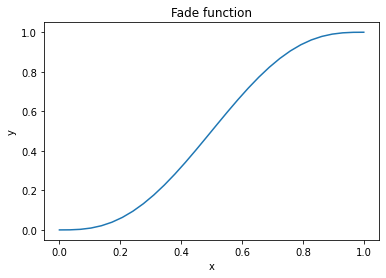

In [18]:
X = np.linspace(0, 1, 30)
Y = [fade(x) for x in X] 
plt.plot(X, Y)
plt.xlabel("x")
plt.ylabel("y")
show('Fade function')

#### 7) Wrap up <a id="wrap_up" />
Finally, let's write the Perlin Noise function, which takes $x$ and $y$ and returns the gradient value.

In [19]:
def perlin_noise(x, y, gradient_vectors, distances, grid_size, side_length): 
    # Distance vectos
    dbl, dbr, dtl, dtr = get_distance_vectors(x, y, grid_size, distances)
    
    # Gradient vectors indexes
    if y % 2 != 0: 
        y -= 1
    
    gbl_ind = int(x / grid_size) + int(y / grid_size) * side_length
    gbr_ind = gbl_ind + 1
    gtl_ind = gbr_ind + side_length - 1
    gtr_ind = gtl_ind + 1
    
    # Gradient vectors
    gbl = gradient_vectors[gbl_ind]
    gbr = gradient_vectors[gbr_ind]
    gtl = gradient_vectors[gtl_ind]
    gtr = gradient_vectors[gtr_ind]
        
    # Compute influence values
    inf_bl = get_dot_product(gbl, dbl)
    inf_br = get_dot_product(gbr, dbr)
    inf_tl = get_dot_product(gtl, dtl)
    inf_tr = get_dot_product(gtr, dtr)
    
    # Interpolate values
    # dbl[0] == weight x
    # dbl[1] == weight y
    l1 = get_bilinear_interpolation(inf_bl, inf_br, fade(dbl[0]))
    l2 = get_bilinear_interpolation(inf_tl, inf_tr, fade(dbl[0]))
    noise = get_bilinear_interpolation(l1, l2, fade(dbl[1]))

    return noise

In [20]:
def get_coloured_image(matrix_size, grid_ratio):
    X, Y, grid_size, side_length = get_grids_points(matrix_size, grid_ratio)
    gradient_vectors = get_gradient_vectors(len(X))
    distances = np.linspace(0, 1, grid_size)

    # We traverse all pixels
    noise_arr = []
    for y in range(matrix_size): 
        for x in range(matrix_size):
            noise = perlin_noise(x, y, gradient_vectors, distances, grid_size, side_length)
            noise_arr.append(noise)
            
    gradient = np.reshape(noise_arr, [matrix_size, matrix_size])
    
    return gradient

def show_2d_coloured_image(gradient, title, cmap=None):
    show_image(gradient, title, cmap)
    return

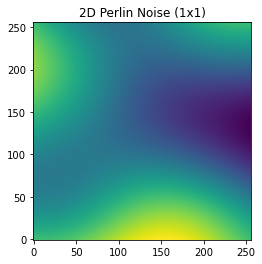

In [21]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 1)
show_2d_coloured_image(gradient, title = "2D Perlin Noise (1x1)")

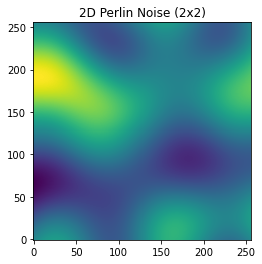

In [22]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 2)
show_2d_coloured_image(gradient, title = "2D Perlin Noise (2x2)")

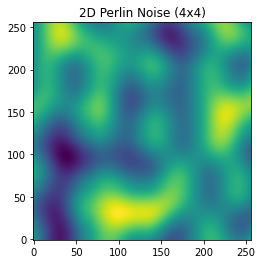

In [23]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 4)
show_2d_coloured_image(gradient, title = "2D Perlin Noise (4x4)")

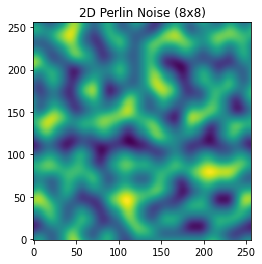

In [24]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 8)
show_2d_coloured_image(gradient, title = "2D Perlin Noise (8x8)")

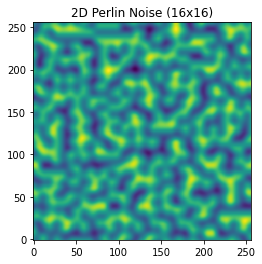

In [25]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 16)
show_2d_coloured_image(gradient, title = "2D Perlin Noise (16x16)")

We can see that our results are very similar to those in the black and white picture above. Because of this and the fluent transition from one colour to another, we can conclude that we have successfully coloured an image.

#### Practical Example <a id="practical_example" />
If we use color map "hot", our image will look like randomly generated lava. In this way using different parameters we can generate different gradients depending on our use case.

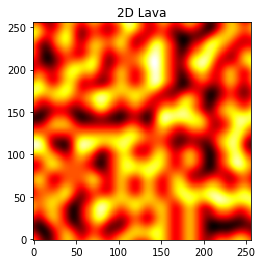

In [26]:
gradient = get_coloured_image(matrix_size = 256, grid_ratio = 8)
show_2d_coloured_image(gradient, title = "2D Lava", cmap = "hot")

2D Perlin Noise can be used as a 3D map generator, but in this way, you have less control over the octaves and the persistence. Bellow you can see an example of map generating with 2D Perlin Noise.

In [27]:
def show_3d_gradient(gradient):
    gradient_length = len(gradient)

    lin_x = np.linspace(0, 1, gradient_length, endpoint=False)
    lin_y = np.linspace(0, 1, gradient_length, endpoint=False)
    x,y = np.meshgrid(lin_x, lin_y)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, gradient, cmap='terrain')
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.title("3D Terrain")
    plt.show()

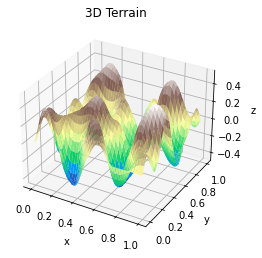

In [28]:
gradient = get_coloured_image(matrix_size=256, grid_ratio=4)
show_3d_gradient(gradient)

#### References: 
* [Perlin Noise Video](https://www.youtube.com/watch?v=MJ3bvCkHJtE)
* [Perlin Noise Article by Adrian Biagioli](https://adrianb.io/2014/08/09/perlinnoise.html)
* [Perlin Noise Article from Wikipedia](https://en.wikipedia.org/wiki/Perlin_noise)
* [Perlin Noise Article by Lars Huttar](https://www.huttar.net/lars-kathy/graphics/perlin-noise/perlin-noise.html)